# Sentiment Analysis with BERT

Name: Santosh Kumar | 
Email Id: santhokuma@vmware.com | 
Director, Global SI/SO Technical Alliances | 
Address: Kalyani Vista, Doraisanipalya, 4th Phase JP Nagar, Bengaluru – 560076 


High Level Steps

- Preprocess text data for BERT and build PyTorch Dataset (tokenization, attention masks, and padding)
- Use Transfer Learning to build Sentiment Classifier using the Transformers library by Hugging Face
- Evaluate the model on test data
- Predict sentiment on raw text



In [1]:
!nvidia-smi

/bin/sh: nvidia-smi: command not found


Here we are using BERT, it stands for Bidirectional Encoder Representations from Transformers. 

- Bidirectional: to understand the text it does both, look back(i.e. at the previous words) and look forward( i.e. at the next words)
- Transformers: The Transformer reads entire sequences of tokens at once. In a sense, the model is non-directional, while LSTMs read sequentially(left-to-right or right-to-left). The attention mechanism allows for learning contextual relations between words (e.g. `his` in a sentence refers to Jim).
- (Pre-trained) contextualized word embeddings is a way to encode words based on their meaning/context. 

BERT was trained by masking 15% of the tokens with the goal to guess them. An additional objective was to predict the next sentence. 

The BERT paper was released along with [the source code](https://github.com/google-research/bert) and pre-trained models.

## Setup

[The Transformers library](https://huggingface.co/transformers/) by Hugging Face:

In [2]:
!pip install -q -U watermark

In [3]:
!pip install -qq transformers

In [4]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [5]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.7.3
IPython 7.15.0

numpy 1.18.5
pandas 1.0.4
torch 1.5.0
transformers 2.11.0


In [6]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Data Exploration

We'll load the reviews dataset provided for Competition i.e. "Export_loop-sentiment-pos-neg-train_05112020000000.csv".

In [7]:
df = pd.read_csv('data/Export_loop-sentiment-pos-neg-train_05112020000000.csv', )
df.head()

,label,text
0,Negative,No one cares about marketing slides - a techni...
1,Positive,Are all three hosts providing storage/capacity...
2,Negative,would loved to had managed to get down to the ...
3,Negative,Vending machine at work is out of Dasani water...
4,Positive,"RT @VMwareEdu: Paul Maritz, CEO and President ..."


In [8]:
df.tail()

,label,text
1895,Positive,It's Friday - and that means the latest episod...
1896,Positive,Your Augmentix A+1950 appears to be nothing mo...
1897,Negative,Eating breakfast. I've attempted to do my make...
1898,Positive,vSAN 6.7 update offers enhanced health checks....
1899,Negative,oh no this is going to be on TMZ tomorrow.


In [9]:
df.values[100]

array(['Positive',
       'http://ow.ly/jFSMx  Hear how World Wide Technology is making business transformations for their customers by partnering with VMware.'],
      dtype=object)

In [10]:
df.shape

(1900, 2)

We have about 1.9k examples. Let's check for missing values:

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1900 entries, 0 to 1899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   1900 non-null   object
 1   text    1900 non-null   object
dtypes: object(2)
memory usage: 29.8+ KB


In [12]:
'''df['text'] = df['text'].str.replace('http\S+|www.\S+', '', case=False)
df['text']= df['text'].str.replace(r"what's", "what is ")
df['text']= df['text'].str.replace(r"\#", "")
df['text']= df['text'].str.replace(r"\'s", " ")
df['text']= df['text'].str.replace(r"\'ve", " have ")
df['text']= df['text'].str.replace(r"can\'t", "cannot ")
df['text']= df['text'].str.replace(r"n\'t", " not ")
df['text']= df['text'].str.replace(r"i\'m", "i am ")
df['text']= df['text'].str.replace(r"\'re", " are ")
df['text']= df['text'].str.replace(r"\'d", " would ")
df['text']= df['text'].str.replace(r"\'ll", " will ")
df['text']= df['text'].str.replace(r"e - mail", "email")
df['text']= df['text'].str.replace(r"<[^>]+>", "")
# Remove punctuations and numbers
df['text']= df['text'].str.replace("[^a-zA-Z]", ' ')
# Single character removal
df['text']= df['text'].str.replace(r"\s+[a-zA-Z]\s+", ' ')
# Removing multiple spaces
df['text']= df['text'].str.replace(r'\s+', ' ')
df['text']= df['text'].str.replace(r" m ", " I am ")'''

'df[\'text\'] = df[\'text\'].str.replace(\'http\\S+|www.\\S+\', \'\', case=False)\ndf[\'text\']= df[\'text\'].str.replace(r"what\'s", "what is ")\ndf[\'text\']= df[\'text\'].str.replace(r"\\#", "")\ndf[\'text\']= df[\'text\'].str.replace(r"\'s", " ")\ndf[\'text\']= df[\'text\'].str.replace(r"\'ve", " have ")\ndf[\'text\']= df[\'text\'].str.replace(r"can\'t", "cannot ")\ndf[\'text\']= df[\'text\'].str.replace(r"n\'t", " not ")\ndf[\'text\']= df[\'text\'].str.replace(r"i\'m", "i am ")\ndf[\'text\']= df[\'text\'].str.replace(r"\'re", " are ")\ndf[\'text\']= df[\'text\'].str.replace(r"\'d", " would ")\ndf[\'text\']= df[\'text\'].str.replace(r"\'ll", " will ")\ndf[\'text\']= df[\'text\'].str.replace(r"e - mail", "email")\ndf[\'text\']= df[\'text\'].str.replace(r"<[^>]+>", "")\n# Remove punctuations and numbers\ndf[\'text\']= df[\'text\'].str.replace("[^a-zA-Z]", \' \')\n# Single character removal\ndf[\'text\']= df[\'text\'].str.replace(r"\\s+[a-zA-Z]\\s+", \' \')\n# Removing multiple spaces

In [13]:
df.head()

,label,text
0,Negative,No one cares about marketing slides - a techni...
1,Positive,Are all three hosts providing storage/capacity...
2,Negative,would loved to had managed to get down to the ...
3,Negative,Vending machine at work is out of Dasani water...
4,Positive,"RT @VMwareEdu: Paul Maritz, CEO and President ..."


No missing values in the score and review texts! Do we have class imbalance?

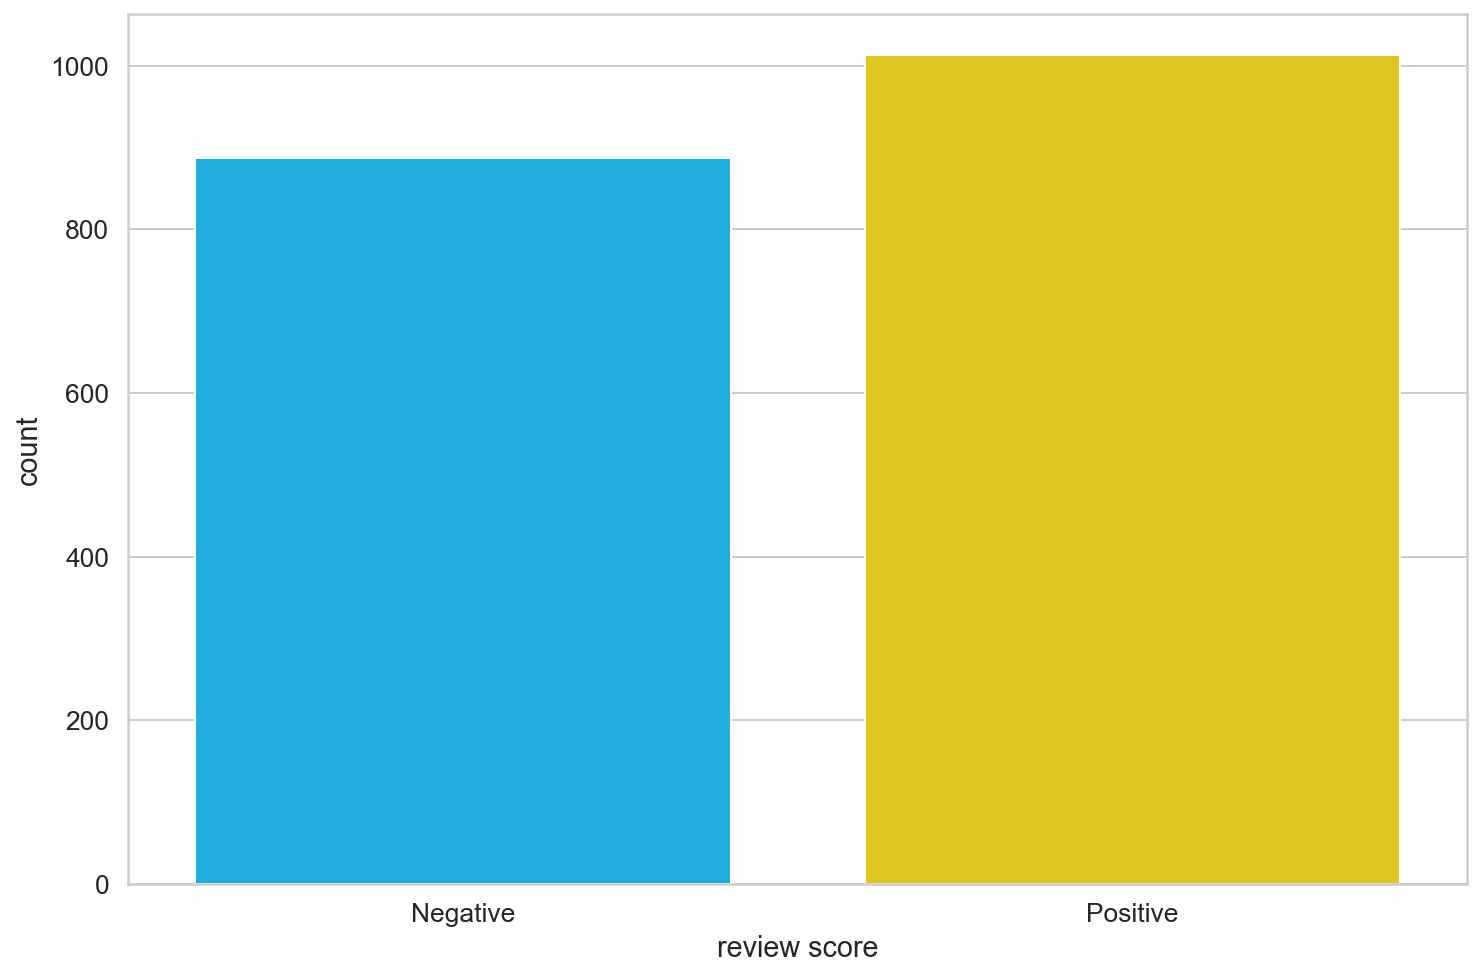

In [14]:
sns.countplot(df.label)
plt.xlabel('review score');

That's relatively balanced. We're going to convert the dataset into negative and positive sentiment.

In [15]:
def to_sentiment(label):
  if label == "Positive":
    return 1
  elif label == "Negative":
    return 0

df['blabel'] = df.label.apply(to_sentiment)

In [16]:
class_names = ['Negative', 'Positive']

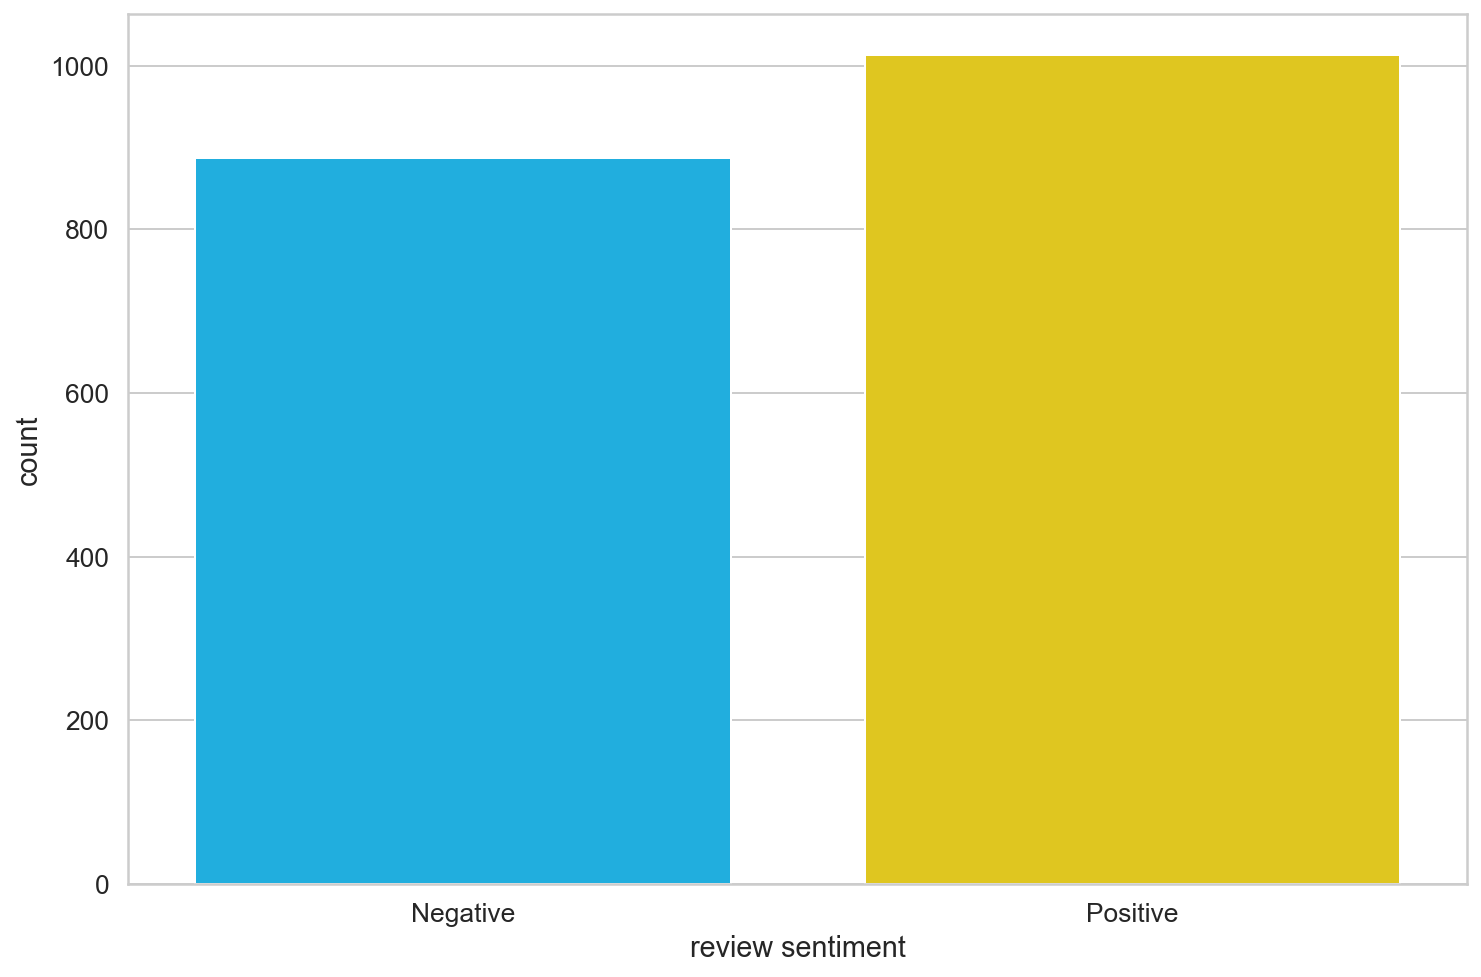

In [17]:
ax = sns.countplot(df.blabel)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

Cross checked the balance.

## Data Preprocessing

You might already know that Machine Learning models don't work with raw text. You need to convert text to numbers (of some sort). BERT requires even more attention (good one, right?). Here are the requirements: 

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*

The Transformers library provides (you've guessed it) a wide variety of Transformer models (including BERT). It works with TensorFlow and PyTorch! It also includes prebuild tokenizers that do the heavy lifting for us!


In [18]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

> You can use a cased and uncased version of BERT and tokenizer. I've experimented with both. The cased version works better. Intuitively, that makes sense, since "BAD" might convey more sentiment than "bad".

Let's load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [19]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

We'll use this text to understand the tokenization process:

In [20]:
sample_txt = 'VMware is top private cloud company in the world. VMware has partnered with hypersclares to become top multi cloud company.'

Some basic operations can convert the text to tokens and tokens to unique integers (ids):

In [21]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: VMware is top private cloud company in the world. VMware has partnered with hypersclares to become top multi cloud company.
   Tokens: ['V', '##M', '##ware', 'is', 'top', 'private', 'cloud', 'company', 'in', 'the', 'world', '.', 'V', '##M', '##ware', 'has', 'partnered', 'with', 'h', '##yper', '##s', '##c', '##lar', '##es', 'to', 'become', 'top', 'multi', 'cloud', 'company', '.']
Token IDs: [159, 2107, 7109, 1110, 1499, 2029, 7180, 1419, 1107, 1103, 1362, 119, 159, 2107, 7109, 1144, 12690, 1114, 177, 24312, 1116, 1665, 5815, 1279, 1106, 1561, 1499, 4321, 7180, 1419, 119]


### Special Tokens

`[SEP]` - marker for ending of a sentence


In [22]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

`[CLS]` - we must add this token to the start of each sentence, so BERT knows we're doing classification

In [23]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

There is also a special token for padding:

In [24]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

BERT understands tokens that were in the training set. Everything else can be encoded using the `[UNK]` (unknown) token:

In [25]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

All of that work can be done using the [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method:

In [26]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=256,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    truncation=True,
    return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 32:

In [27]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

256


tensor([  101,   159,  2107,  7109,  1110,  1499,  2029,  7180,  1419,  1107,
         1103,  1362,   119,   159,  2107,  7109,  1144, 12690,  1114,   177,
        24312,  1116,  1665,  5815,  1279,  1106,  1561,  1499,  4321,  7180,
         1419,   119,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

The attention mask has the same length:

In [28]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

256


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

We can inverse the tokenization to have a look at the special tokens:

In [29]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'V',
 '##M',
 '##ware',
 'is',
 'top',
 'private',
 'cloud',
 'company',
 'in',
 'the',
 'world',
 '.',
 'V',
 '##M',
 '##ware',
 'has',
 'partnered',
 'with',
 'h',
 '##yper',
 '##s',
 '##c',
 '##lar',
 '##es',
 'to',
 'become',
 'top',
 'multi',
 'cloud',
 'company',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[

### Choosing Sequence Length

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [30]:
token_lens = []

for txt in df.text:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

and plot the distribution:

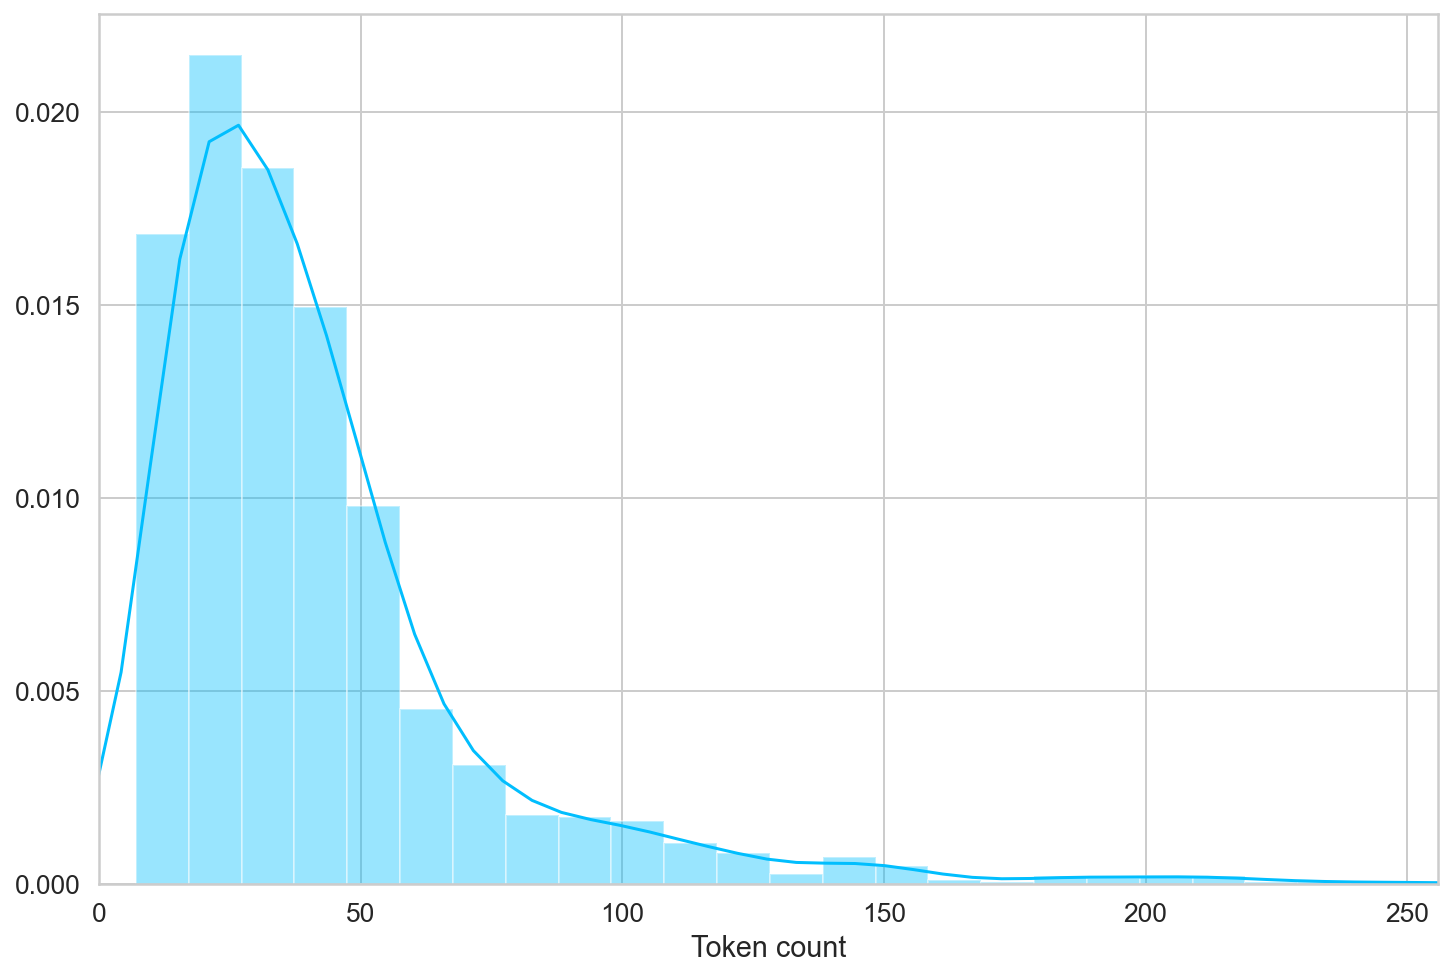

In [31]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 128 tokens, but we'll be on the safe side and choose a maximum length of 160.

In [32]:
MAX_LEN = 256

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [33]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
      truncation = True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

In [34]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [35]:
df_train.shape, df_val.shape, df_test.shape

((1710, 3), (95, 3), (95, 3))

We also need to create a couple of data loaders. Here's a helper function to do it:

In [36]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text.to_numpy(),
    targets=df.blabel.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [37]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from our training data loader:

In [38]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [39]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])


## Sentiment Classification with BERT and Hugging Face

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) or something else. 

But who cares, right? We're *hardcore*! We'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it. Let's load the model:

In [40]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

And try to use it on the encoding of our sample text:

In [41]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

The `last_hidden_state` is a sequence of hidden states of the last layer of the model. Obtaining the `pooled_output` is done by applying the [BertPooler](https://github.com/huggingface/transformers/blob/edf0582c0be87b60f94f41c659ea779876efc7be/src/transformers/modeling_bert.py#L426) on `last_hidden_state`:

In [42]:
last_hidden_state.shape

torch.Size([1, 256, 768])

We have the hidden state for each of our 32 tokens (the length of our example sequence). But why 768? This is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [43]:
bert_model.config.hidden_size

768



You can think of the `pooled_output` as a summary of the content, according to BERT. Albeit, you might try and do better. Let's look at the shape of the output:

In [44]:
pooled_output.shape

torch.Size([1, 768])

We can use all of this knowledge to create a classifier that uses the BERT model:

In [45]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [46]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

We'll move the example batch of our training data to the GPU:

In [47]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 256])
torch.Size([16, 256])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [48]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.7941, 0.2059],
        [0.7215, 0.2785],
        [0.6551, 0.3449],
        [0.7257, 0.2743],
        [0.6849, 0.3151],
        [0.7388, 0.2612],
        [0.7686, 0.2314],
        [0.7990, 0.2010],
        [0.6886, 0.3114],
        [0.7003, 0.2997],
        [0.6294, 0.3706],
        [0.5592, 0.4408],
        [0.8296, 0.1704],
        [0.6203, 0.3797],
        [0.7767, 0.2233],
        [0.7020, 0.2980]], grad_fn=<SoftmaxBackward>)

### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [49]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=3e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Let's continue with writing a helper function for training our model for one epoch:

In [50]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader:

In [51]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history:

In [52]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  torch.save(model.state_dict(), f'best_model_state_{epoch}_1.bin')

  #if val_acc > best_accuracy:
  #  torch.save(model.state_dict(), 'best_model_state_1.bin')
  #  best_accuracy = val_acc

Epoch 1/5
----------
Train loss 0.5068282397272431 accuracy 0.7567251461988304
Val   loss 0.4083639731009801 accuracy 0.8105263157894737

Epoch 2/5
----------
Train loss 0.24531976538753816 accuracy 0.9192982456140351
Val   loss 0.43439531822999317 accuracy 0.8421052631578947

Epoch 3/5
----------
Train loss 0.10601397587756722 accuracy 0.9766081871345029
Val   loss 0.7868462167680264 accuracy 0.8210526315789474

Epoch 4/5
----------
Train loss 0.048773218278129034 accuracy 0.9883040935672515
Val   loss 0.6762410775215054 accuracy 0.8631578947368421

Epoch 5/5
----------
Train loss 0.020916440592160464 accuracy 0.995906432748538
Val   loss 0.7753231466437379 accuracy 0.8526315789473684

CPU times: user 20h 22min, sys: 1h 25min 55s, total: 21h 47min 55s
Wall time: 3h 7min 46s


Note that we're storing the state of the best model, indicated by the highest validation accuracy.

Whoo, this took some time! We can look at the training vs validation accuracy:

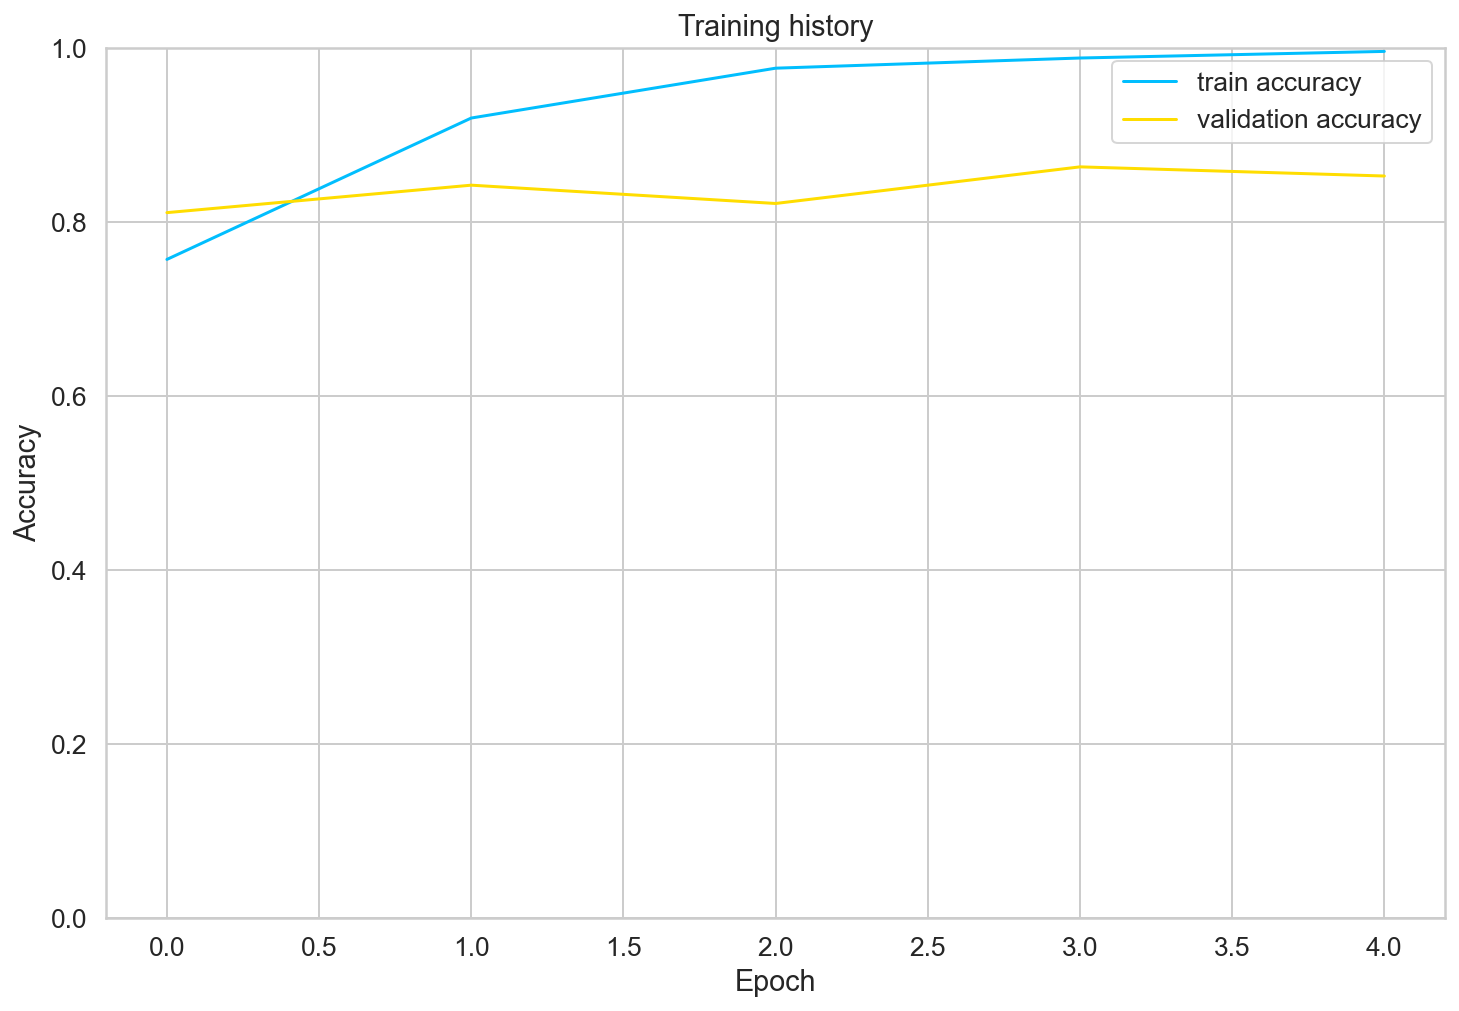

In [53]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

The training accuracy starts to approach 100% after 10 epochs or so. You might try to fine-tune the parameters a bit more, but this will be good enough for us.

Don't want to wait? Uncomment the next cell to download my pre-trained model:

In [72]:
# !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state_3_1.bin'))
model = model.to(device)

## Evaluation

So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [73]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.8526315789473684

The accuracy is about 1% lower on the test set. Our model seems to generalize well.

We'll define a helper function to get the predictions from our model:

In [74]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [75]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Let's have a look at the classification report

In [76]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    Negative       0.83      0.83      0.83        42
    Positive       0.87      0.87      0.87        53

    accuracy                           0.85        95
   macro avg       0.85      0.85      0.85        95
weighted avg       0.85      0.85      0.85        95



Looks like it is really hard to classify neutral (3 stars) reviews. And I can tell you from experience, looking at many reviews, those are hard to classify.

We'll continue with the confusion matrix:

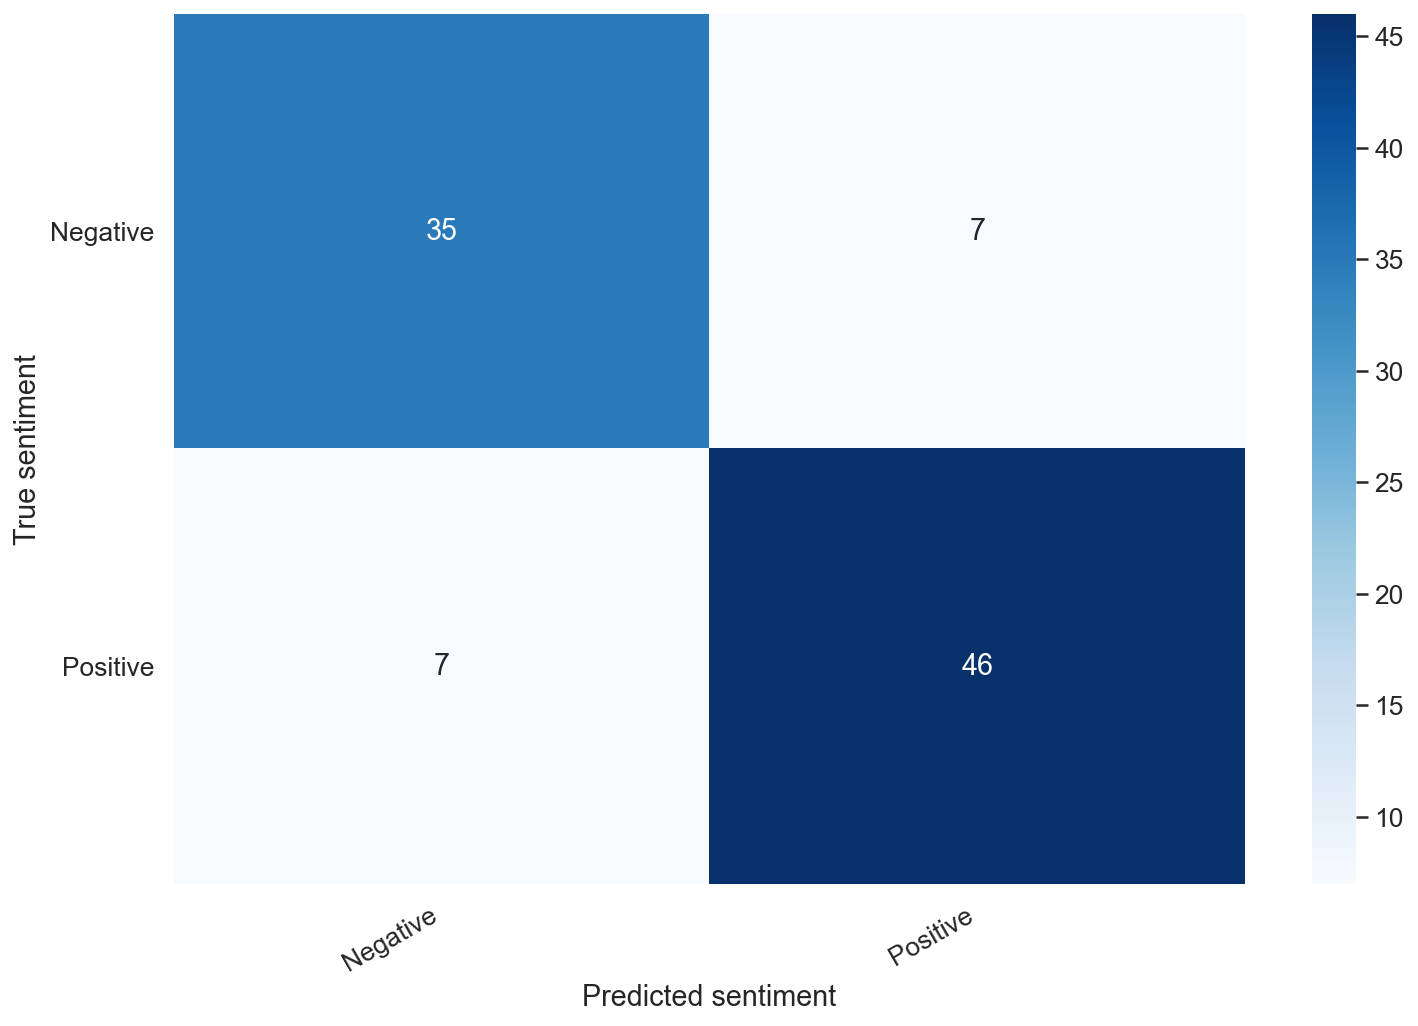

In [77]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That's a good overview of the performance of our model. But let's have a look at an example from our test data:

In [78]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [79]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

I'm not even sure that is an option anymore.  The only options you can
for memory allocations global to Workstation. It looks like you can
indeed select "Fit all virtual machine memory into reserved host RAM."
But that is not the default setting.

True sentiment: Negative


Now we can look at the confidence of each sentiment of our model:

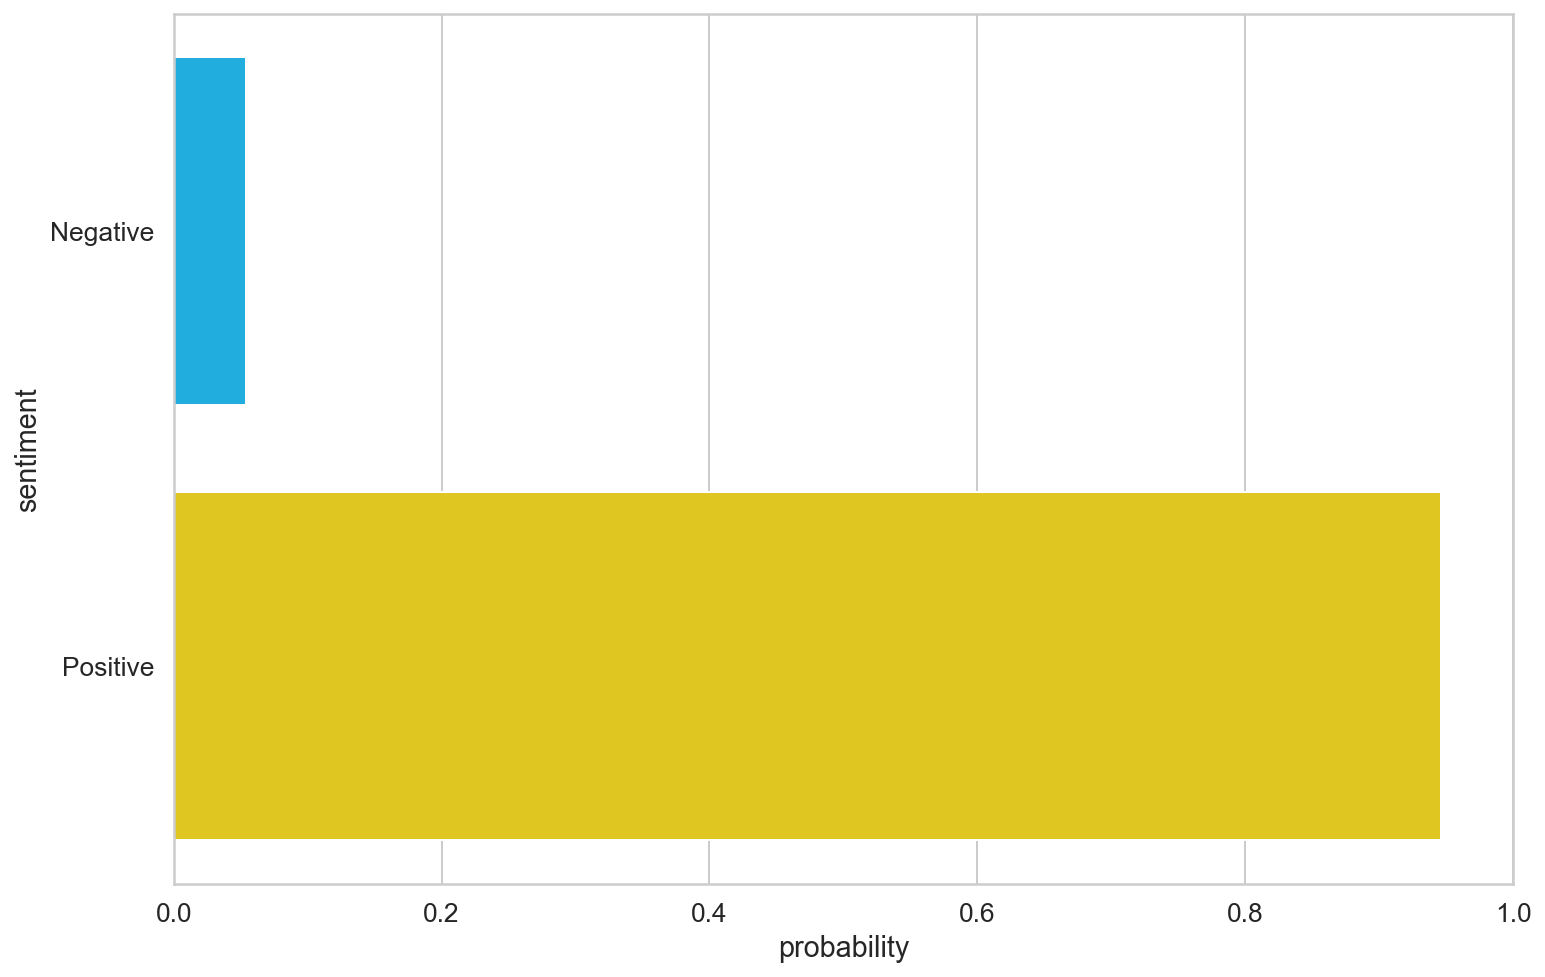

In [80]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

In [81]:
df_eval = pd.read_csv('data/sentiment-eval.csv', )
df_eval.set_index('id')
df_eval.head()

,id,text
0,0,it's not like I haven't been talking about it ...
1,1,"With a modern data center, you can cut costs a..."
2,2,"In today's storage landscape, there is a myria..."
3,3,I hoped that it could be done via GUI. I didn...
4,4,math final tomorrow...im getting an ulcer over it


In [82]:
df_eval.shape

(211, 2)

We have to use the tokenizer to encode the text:

In [83]:
df_eval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 0 to 210
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      211 non-null    int64 
 1   text    211 non-null    object
dtypes: int64(1), object(1)
memory usage: 3.4+ KB


In [84]:
'''df_eval['text']= df_eval['text'].str.replace('http\S+|www.\S+', '', case=False)
df_eval['text']= df_eval['text'].str.replace(r"what's", "what is ")
df_eval['text']= df_eval['text'].str.replace(r"\#", "")
df_eval['text']= df_eval['text'].str.replace(r"\'s", " ")
df_eval['text']= df_eval['text'].str.replace(r"\'ve", " have ")
df_eval['text']= df_eval['text'].str.replace(r"can\'t", "cannot ")
df_eval['text']= df_eval['text'].str.replace(r"n\'t", " not ")
df_eval['text']= df_eval['text'].str.replace(r"i\'m", "i am ")
df_eval['text']= df_eval['text'].str.replace(r"\'re", " are ")
df_eval['text']= df_eval['text'].str.replace(r"\'d", " would ")
df_eval['text']= df_eval['text'].str.replace(r"\'ll", " will ")
df_eval['text']= df_eval['text'].str.replace(r"e - mail", "email")
df['text']= df['text'].str.replace(r"<[^>]+>", "")
# Remove punctuations and numbers
df_eval['text']= df_eval['text'].str.replace("[^a-zA-Z]", ' ')
# Single character removal
df_eval['text']= df_eval['text'].str.replace(r"\s+[a-zA-Z]\s+", ' ')
# Removing multiple spaces
df_eval['text']= df_eval['text'].str.replace(r'\s+', ' ')
df_eval['text']= df_eval['text'].str.replace(r" m ", " I am ")'''

'df_eval[\'text\']= df_eval[\'text\'].str.replace(\'http\\S+|www.\\S+\', \'\', case=False)\ndf_eval[\'text\']= df_eval[\'text\'].str.replace(r"what\'s", "what is ")\ndf_eval[\'text\']= df_eval[\'text\'].str.replace(r"\\#", "")\ndf_eval[\'text\']= df_eval[\'text\'].str.replace(r"\'s", " ")\ndf_eval[\'text\']= df_eval[\'text\'].str.replace(r"\'ve", " have ")\ndf_eval[\'text\']= df_eval[\'text\'].str.replace(r"can\'t", "cannot ")\ndf_eval[\'text\']= df_eval[\'text\'].str.replace(r"n\'t", " not ")\ndf_eval[\'text\']= df_eval[\'text\'].str.replace(r"i\'m", "i am ")\ndf_eval[\'text\']= df_eval[\'text\'].str.replace(r"\'re", " are ")\ndf_eval[\'text\']= df_eval[\'text\'].str.replace(r"\'d", " would ")\ndf_eval[\'text\']= df_eval[\'text\'].str.replace(r"\'ll", " will ")\ndf_eval[\'text\']= df_eval[\'text\'].str.replace(r"e - mail", "email")\ndf[\'text\']= df[\'text\'].str.replace(r"<[^>]+>", "")\n# Remove punctuations and numbers\ndf_eval[\'text\']= df_eval[\'text\'].str.replace("[^a-zA-Z]", \

In [85]:
encoded_review = tokenizer.batch_encode_plus(
    df_eval.text.values,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
    truncation=True
)


Let's get the predictions from our model:

In [86]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)


In [87]:
prediction

tensor([0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
        1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
        0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
        1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0])

In [88]:
import csv 

with open('data/results_3_1.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["id", "label"])

In [89]:
with open('data/results.csv_3_1', 'a') as file:
    writer = csv.writer(file)
    j = 0
    for i in prediction:
        writer.writerow([j, (lambda x: "Positive" if x==1 else "Negative")(prediction[i])])
        j = j + 1

## Summary

This uses BERT for sentiment analysis, a custom classifier using the Hugging Face library and trained it on given dataset!

- [Read the tutorial](https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)

I used my system to run the cide

- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S)
- [Read the `Getting Things Done with Pytorch` book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

You learned how to:

- Intuitively understand what BERT is
- Preprocess text data for BERT and build PyTorch Dataset (tokenization, attention masks, and padding)
- Use Transfer Learning to build Sentiment Classifier using the Transformers library by Hugging Face
- Evaluate the model on test data
- Predict sentiment on raw text

Next, we'll learn how to deploy our trained model behind a REST API and build a simple web app to access it.

## References

- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
- [L11 Language Models - Alec Radford (OpenAI)](https://www.youtube.com/watch?v=BnpB3GrpsfM)
- [The Illustrated BERT, ELMo, and co.](https://jalammar.github.io/illustrated-bert/)
- [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/)
- [How to Fine-Tune BERT for Text Classification?](https://arxiv.org/pdf/1905.05583.pdf)
- [Huggingface Transformers](https://huggingface.co/transformers/)
- [BERT Explained: State of the art language model for NLP](https://towardsdatascience.com/bert-explained-state-of-the-art-language-model-for-nlp-f8b21a9b6270)